In [71]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.preprocessing import scale
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization and Preprocessing

In [2]:
df = pd.read_excel("referentiel-archeologique-de-paris.xlsx")
print(f"Shape: {df.shape}")
df.head()

Shape: (1811, 18)


,Identifiant,Adresse,Code postal,Commune,Nature de l'opération,Responsable de l'opération,Date de l'opération,Préhistoire,Protohistoire,Antiquité,Moyen-Age,Temps modernes,Epoque contemporaine,Synthèse,X,Y,geo_shape,geo_point_2d
0,83,1 rue du Petit-Musc,75004,Paris,Découverte ancienne,Magne Charles,1911,NaN,Non,Non,Oui,Non,Non,"En 1911, lors de fouilles pour la construction...",653220.673,6861470.20,"{""type"": ""Point"", ""coordinates"": [2.3625059708...","48.851573509, 2.36250597088"
1,1373,24 rue Auguste Chabrières,75015,Paris,Diagnostic,Marti Fabrice,2005,NaN,Oui,Non,Non,Non,Non,Aucun vestige archéologique n'a été repéré lor...,647842.180,6859634.74,"{""type"": ""Point"", ""coordinates"": [2.2894383862...","48.8346542641, 2.28943838628"
2,111,1 avenue de l Opéra,75001,Paris,Découverte ancienne,Magne Charles,1912 - 1913,NaN,Non,Non,Non,Non,Non,Les fouilles pour la construction de la ligne ...,651208.276,6862872.70,"{""type"": ""Point"", ""coordinates"": [2.3349219470...","48.8640367087, 2.33492194704"
3,1655,4 rue Scipion,75005,Paris,Découverte ancienne,Vacquer Théodore,1868,NaN,Non,Non,Non,Non,Non,"Th. Vacquer signale la découverte, le 20 juill...",652586.772,6859979.93,"{""type"": ""Point"", ""coordinates"": [2.3540338871...","48.838125107, 2.35403388717"
4,33,18 rue du Cloître Saint-Merri,75004,Paris,Découverte ancienne,Magne Charles,1911,NaN,Non,Non,Oui,Non,Non,Trois chapiteaux sculptés (XVe-XVIe siècles) o...,652384.436,6862334.37,"{""type"": ""Point"", ""coordinates"": [2.3510137149...","48.8592836047, 2.35101371494"


In [3]:
df.isna().sum()

Identifiant                      0
Adresse                          0
Code postal                      0
Commune                         45
Nature de l'opération          113
Responsable de l'opération     326
Date de l'opération            121
Préhistoire                   1811
Protohistoire                    0
Antiquité                        0
Moyen-Age                        0
Temps modernes                   0
Epoque contemporaine             1
Synthèse                         8
X                                0
Y                                0
geo_shape                        0
geo_point_2d                     0
dtype: int64

In [4]:
df["Nature de l'opération"].fillna("Unknown", inplace=True)
df["Responsable de l'opération"].fillna("Unknown", inplace=True)
df["Epoque contemporaine"].fillna("Non", inplace=True)

In [5]:
for column in ["Commune", "Nature de l'opération", "Code postal", "Protohistoire", "Antiquité", "Moyen-Age", "Temps modernes", "Epoque contemporaine"]:
    print(f"> {column}: {df[column].unique()}")

> Commune: ['Paris' nan]
> Nature de l'opération: ['Découverte ancienne' 'Diagnostic' 'Fouille' 'Unknown' 'Sondage'
 'Suivi de travaux' 'Sauvetage urgent' 'Découverte fortuite'
 'Dossier administratif' 'SP' 'Évaluation archéologique'
 'Étude documentaire' 'Autres études' 'Étude du bâti']
> Code postal: [75004 75015 75001 75005 75006 75018 75003 75020 75014 75013 75016 75012
 75007 75002 75011 75017 75010 75009 75019 75008]
> Protohistoire: ['Non' 'Oui']
> Antiquité: ['Non' 'Oui']
> Moyen-Age: ['Oui' 'Non']
> Temps modernes: ['Non' 'Oui']
> Epoque contemporaine: ['Non' 'Oui']


In [6]:
n = len(df["Responsable de l'opération"].unique())
print(f"Nombre de responsables: {n}")

Nombre de responsables: 134


In [7]:
dates = []
sum_ = 0
count = 0
for date in df["Date de l'opération"]:
    try:
        if type(date) is str:
            date = date[:4]
            
        x = int(date)
        dates.append(x)
        sum_ += x
        count += 1
    
    except:
        dates.append(-1)
        
mean = int(sum_/count)
dates = [mean if date==-1 else date for date in dates]
df["Date"] = dates
print(f"Min date: {min(df['Date'])}")
print(f"Max date: {max(df['Date'])}")

Min date: 1610
Max date: 2020


In [43]:
df["Secular"] = df["Date"].apply(lambda x: x//100)

epoques = ["Protohistoire", "Antiquité", "Moyen-Age", "Temps modernes", "Epoque contemporaine"]
l = []
for _, row in df.iterrows():
    known = False
    for epoque in epoques:
        if row[epoque] == "Oui":
            l.append(epoque)
            known = True
            break
            
    if not known:
        l.append("Unknown")
    
df["Epoque"] = l

In [52]:
def contingency_analysis(col1, col2):
    contingency = pd.crosstab(df[col1], df[col2])
    print(contingency.to_string())
    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,8))
    mosaic(df,[col1,col2], ax=ax)
    plt.show()

    chi2, pvalue, degrees, expected = chi2_contingency(contingency)
    print(f"Chi2 test p_value: {pvalue}")

Epoque   Antiquité  Epoque contemporaine  Moyen-Age  Protohistoire  Temps modernes  Unknown
Secular                                                                                    
16               7                     0          0              0               0        0
17               8                     0          2              0               0        2
18             350                     0        112              6              18       35
19             357                    40        260             17             157      197
20              47                    19         59             14              47       57


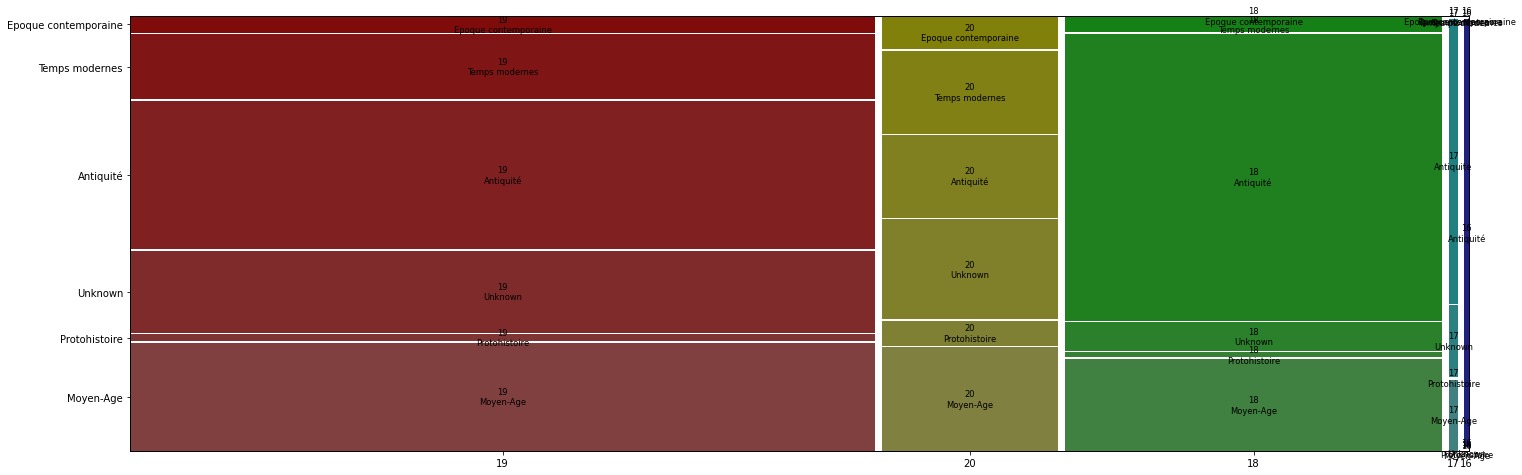

Chi2 test p_value: 4.004588924244994e-48


In [56]:
contingency_analysis("Secular", "Epoque")

Epoque       Antiquité  Epoque contemporaine  Moyen-Age  Protohistoire  Temps modernes  Unknown
Code postal                                                                                    
75001               16                     2         65              2              23       27
75002                1                     1          8              0               4       11
75003                2                     0         29              0              21       21
75004               83                     4        109              1              28       35
75005              414                     6        126              5              34       79
75006              118                     3         56              1              26       30
75007                5                     0          5              2              12        8
75008                0                     2          0              2              10        2
75009                2                  

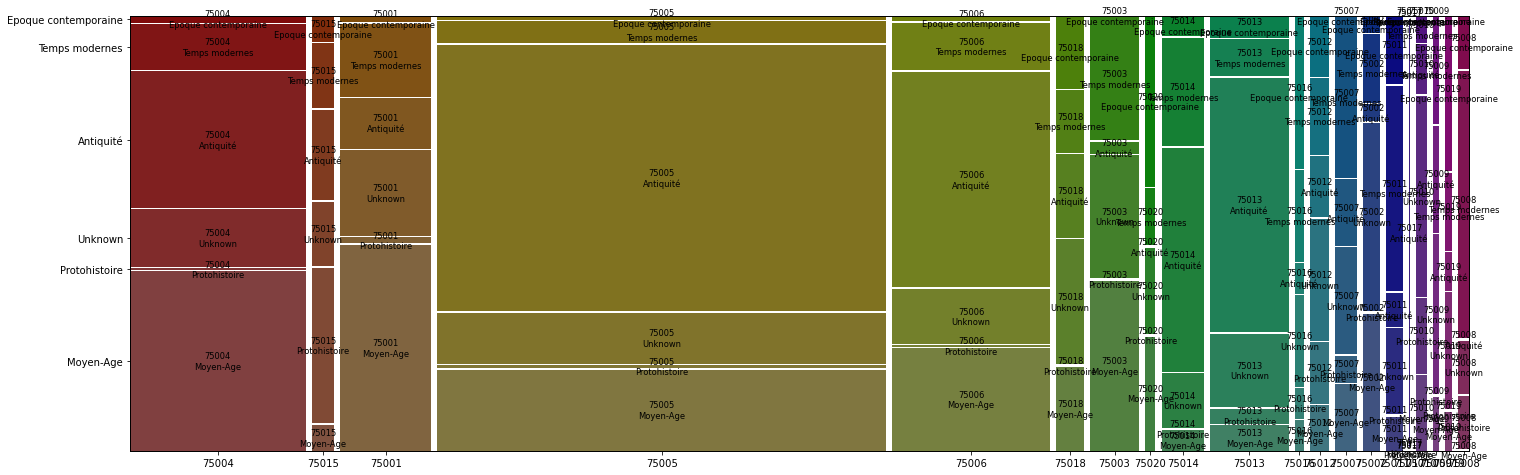

Chi2 test p_value: 8.190882343755305e-151


In [57]:
contingency_analysis("Code postal", "Epoque")

Nature de l'opération  Autres études  Diagnostic  Dossier administratif  Découverte ancienne  Découverte fortuite  Fouille  SP  Sauvetage urgent  Sondage  Suivi de travaux  Unknown  Étude documentaire  Étude du bâti  Évaluation archéologique
Secular                                                                                                                                                                                                                                          
16                                 0           0                      0                    7                    0        0   0                 0        0                 0        0                   0              0                         0
17                                 0           0                      0                   12                    0        0   0                 0        0                 0        0                   0              0                         0
18                              

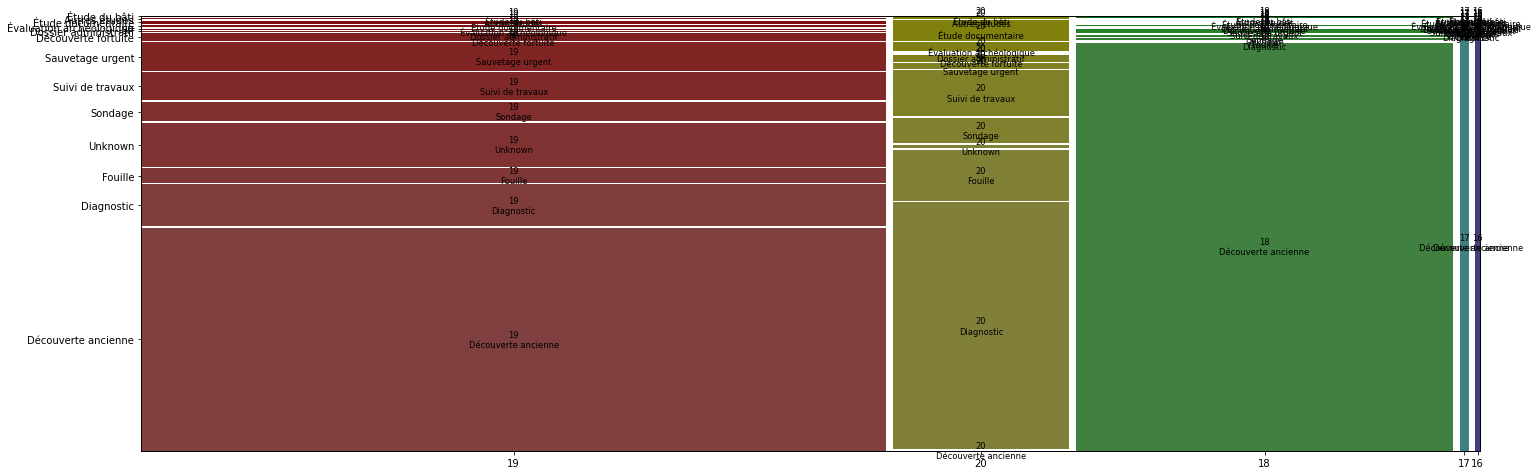

Chi2 test p_value: 6.0893773358163785e-186


In [69]:
contingency_analysis("Secular", "Nature de l'opération")

### Code Postal

In [59]:
features = []
enc = LabelBinarizer()
enc.fit(df["Code postal"])
features.append(list(enc.classes_))
X1 = enc.fit_transform(df["Code postal"])
X1.shape

(1811, 20)

### Opération

In [60]:
enc = LabelBinarizer()
enc.fit(df["Nature de l'opération"])
features.append(list(enc.classes_))
X2 = enc.transform(df["Nature de l'opération"])

In [61]:
enc = LabelBinarizer()
enc.fit(df["Responsable de l'opération"])
features[-1] += list(enc.classes_)

X2 = np.concatenate((X2, enc.transform(df["Responsable de l'opération"])), axis=1)

In [62]:
features[-1].append("Date")
X2 = np.concatenate((X2, np.array(df["Date"]).reshape(-1,1)), axis=1)
X2.shape

(1811, 149)

### Géo

In [108]:
df["geo_shape_x"] = df["geo_shape"].apply(lambda x: eval(x)["coordinates"][0])
df["geo_shape_y"] = df["geo_shape"].apply(lambda x: eval(x)["coordinates"][1])

df["geo_point_2d_x"] = df["geo_point_2d"].apply(lambda x: x[0])
df["geo_point_2d_y"] = df["geo_point_2d"].apply(lambda x: x[1])

X3 = np.array(df[["X", "Y", "geo_shape_x", "geo_shape_y", "geo_point_2d_x", "geo_point_2d_y"]])

### Epoque

In [109]:
Y = np.array(df[epoques].apply(lambda x: x=="Oui"), dtype=int)
Y.shape

(1811, 5)

### Synthèse

In [110]:
df.columns

Index(['Identifiant', 'Adresse', 'Code postal', 'Commune',
       'Nature de l'opération', 'Responsable de l'opération',
       'Date de l'opération', 'Préhistoire', 'Protohistoire', 'Antiquité',
       'Moyen-Age', 'Temps modernes', 'Epoque contemporaine', 'Synthèse', 'X',
       'Y', 'geo_shape', 'geo_point_2d', 'Date', 'Secular', 'Epoque',
       'geo_shape_x', 'geo_shape_y', 'geo_point_2d_x', 'geo_point_2d_y'],
      dtype='object')

In [111]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=0.01)
df["Synthèse"].fillna("", inplace=True)
X4 = tfidf.fit_transform(df["Synthèse"])
print(tfidf.get_feature_names()[:100])
X4.shape

['00', '10', '11', '12', '14', '15', '16', '17', '1844', '1847', '1867', '1868', '1882', '1898', '1899', '1900', '1901', '1903', '1906', '1911', '1912', '1913', '1914', '1925', '1994', '20', '25', '28', '29', '30', '32', '35', '40', '45', '50', '60', '70', '80', '90', 'abandon', 'abbaye', 'abbé', 'abord', 'absence', 'abside', 'accès', 'activité', 'actuel', 'actuelle', 'actuellement', 'afin', 'agir', 'agirait', 'agissait', 'agit', 'agrandissement', 'aile', 'ailleurs', 'ainsi', 'aire', 'ait', 'alignement', 'allant', 'alluvions', 'allée', 'alors', 'aménagement', 'aménagements', 'analyse', 'ancien', 'ancienne', 'anciennes', 'anciens', 'angle', 'animaux', 'année', 'années', 'antique', 'antiques', 'antiquité', 'antoine', 'antérieur', 'antérieure', 'antérieures', 'antérieurs', 'août', 'apparaissent', 'apparaît', 'appareil', 'apparemment', 'appartenant', 'appartenir', 'apport', 'après', 'aqueduc', 'architecte', 'architecture', 'archives', 'archéologie', 'archéologique']


(1811, 1073)

# RGCCA

In [126]:
def pls_reg(X,features=None,epoque_index=None):
    pls2 = PLSRegression()
    if epoque_index is not None:
        pls2.fit(X,Y[:,epoque_index])
    else:
        pls2.fit(X,Y)
        
    if features:
        print("Most important features for first component:\n")
        scores_features = sorted([(-abs(weights[0]), features[i]) for i,weights in enumerate(pls2.x_weights_)])[:10]
        for score, feature in scores_features:
            print(f"{feature} - {-int(score*1e4)/1e4}")
            
        print("\nMost important features for second component:\n")
        scores_features = sorted([(-abs(weights[1]), features[i]) for i,weights in enumerate(pls2.x_weights_)])[:10]
        for score, feature in scores_features:
            print(f"{feature} - {-int(score*1e4)/1e4}")

    X_ = pls2.transform(X)
    if epoque_index is not None:
        plt.scatter(X_[:,0], X_[:,1], c=Y[:,epoque_index])
        plt.title(epoques[epoque_index])
        return
        
    _, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,4))
    for i in range(5):
        ax[i].scatter(X_[:,0], X_[:,1], c=Y[:,i])
        ax[i].set_title(epoques[i])

### Code Postal

Most important features for first component:

75005 - 0.634
75003 - 0.2943
75015 - 0.2583
75001 - 0.2561
75011 - 0.2337
75008 - 0.2048
75012 - 0.2043
75020 - 0.2017
75007 - 0.1897
75016 - 0.1732

Most important features for second component:

75015 - 0.6036
75004 - 0.4722
75001 - 0.3359
75003 - 0.2892
75012 - 0.2173
75016 - 0.1734
75014 - 0.1619
75005 - 0.1604
75019 - 0.1522
75008 - 0.1347


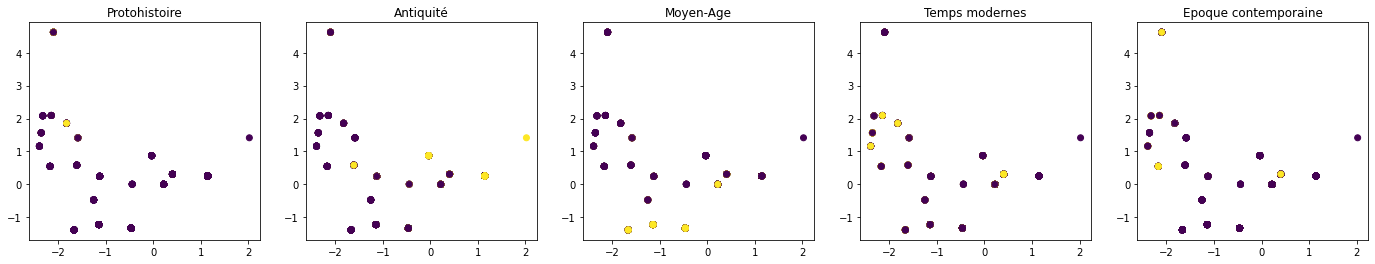

In [118]:
pls_reg(X1, features=features[0])

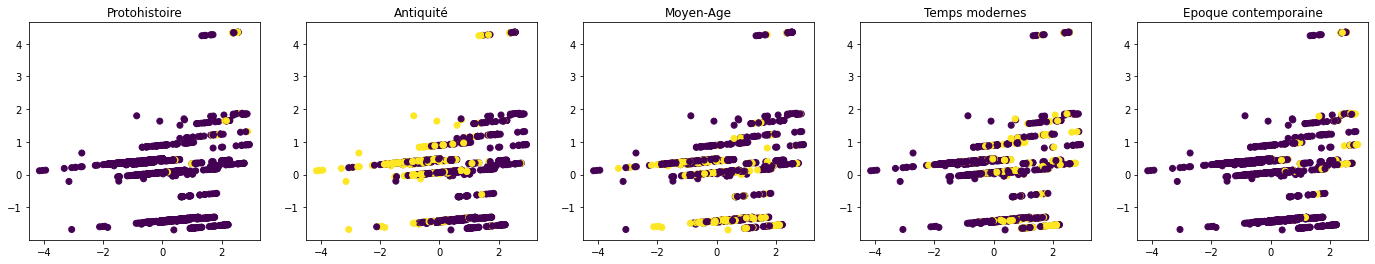

In [114]:
pls_reg(np.concatenate((X1, np.array(df["Date"]).reshape(-1,1)), axis=1))

### Opération

Most important features for first component:

Date - 0.4212
Diagnostic - 0.4131
Vacquer Théodore - 0.4037
Découverte ancienne - 0.3186
Drwila Gabriel - 0.1684
Legriel Jacques - 0.1558
Grimault Prudent Aimé - 0.1386
Marti Fabrice - 0.1326
Mazières Thomas - 0.12
Debouige Priscillia - 0.1153

Most important features for second component:

Marti Fabrice - 0.6637
Limondin Nicole - 0.2507
Souffi Bénédicte - 0.232
Frouin Milléna - 0.2318
Mazières Thomas - 0.2148
Lanchon Yves - 0.2027
De Kisch Yves - 0.166
Vacquer Théodore - 0.1562
Högström A. - 0.1464
Drwila Gabriel - 0.1426


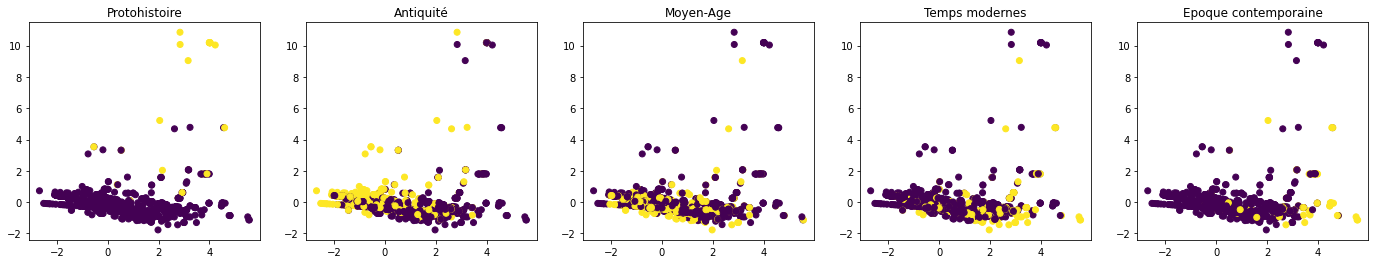

In [204]:
pls_reg(X2, features=features[1])

Most important features for first component:

Unknown - 0.2866
Diagnostic - 0.2075
Découverte ancienne - 0.1891
Grimault Prudent Aimé - 0.1781
Trombetta Pierre-Jean - 0.1748
Sellier Charles - 0.1692
Sauvetage urgent - 0.1583
Fouille - 0.1502
Marti Fabrice - 0.1349
Date - 0.1343

Most important features for second component:

Découverte ancienne - 0.4544
Date - 0.3869
Diagnostic - 0.3473
Vacquer Théodore - 0.3332
Magne Charles - 0.1532
Peixoto Xavier - 0.1463
Unknown - 0.1186
Du Bouétiez Emmanuelle - 0.1162
Sondage - 0.1146
Évaluation archéologique - 0.1056


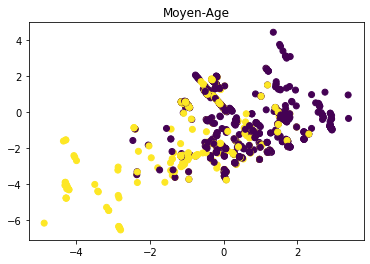

In [143]:
pls_reg(X2, features=features[1], epoque_index=2)

### Géo

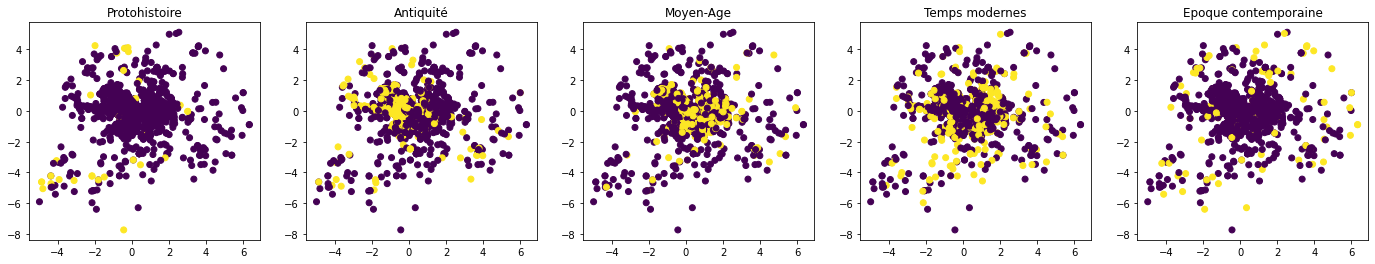

In [115]:
pls_reg(X3)

### Synthèse

Most important features for first component:

vacquer - 0.1661
siècle - 0.1489
voie - 0.1293
th - 0.1259
xviie - 0.1171
antique - 0.1164
xviiie - 0.1109
gallo - 0.109
xvie - 0.1079
xixe - 0.1049

Most important features for second component:

période - 0.1437
xixe - 0.1295
plâtre - 0.1195
sarcophages - 0.1157
occupation - 0.1132
église - 0.1081
structures - 0.1049
seine - 0.1008
phase - 0.1004
site - 0.0959


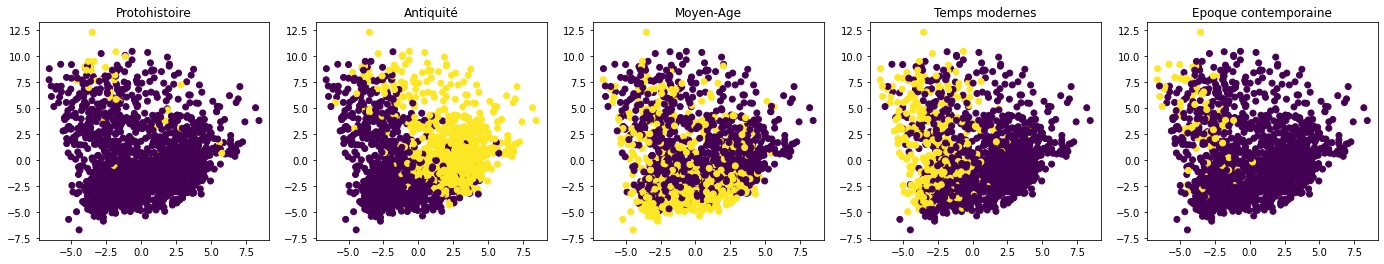

In [116]:
pls_reg(X4.todense(), features=tfidf.get_feature_names())

Most important features for first component:

xiiie - 0.1789
sarcophages - 0.1763
plâtre - 0.1492
xiie - 0.1479
église - 0.1401
auguste - 0.1328
philippe - 0.1297
xive - 0.1253
mérovingienne - 0.1217
moyen - 0.1162

Most important features for second component:

les - 0.1052
ne - 0.1004
le - 0.0987
ces - 0.0932
au - 0.0929
que - 0.089
dans - 0.0872
qui - 0.0869
site - 0.085
sur - 0.0835


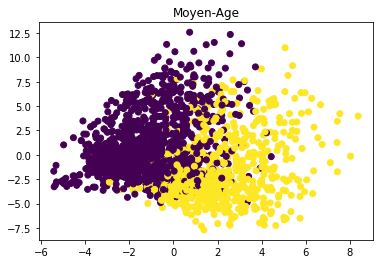

In [158]:
pls_reg(X4.todense(), features=tfidf.get_feature_names(), epoque_index=2)

### Code postal + Opération

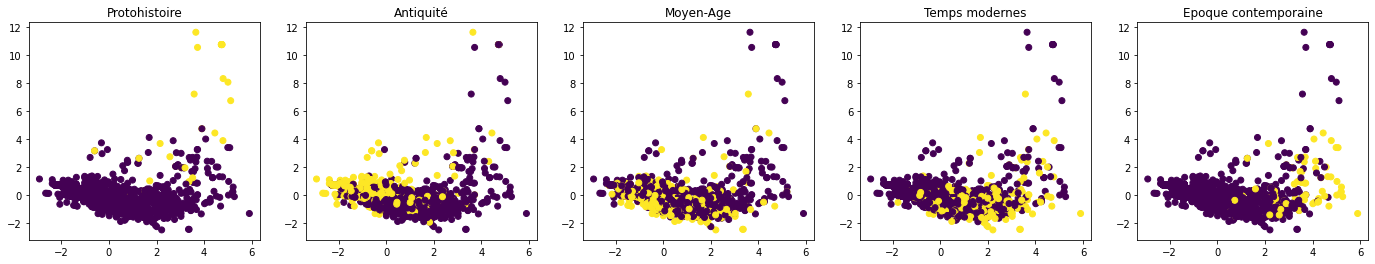

In [113]:
pls_reg(np.concatenate((X1,X2), axis=1))

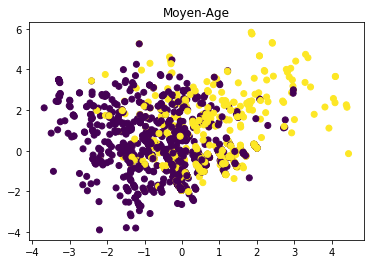

In [156]:
pls_reg(np.concatenate((X1,X2), axis=1), epoque_index=2)

### Code Postal + Opération + Géo

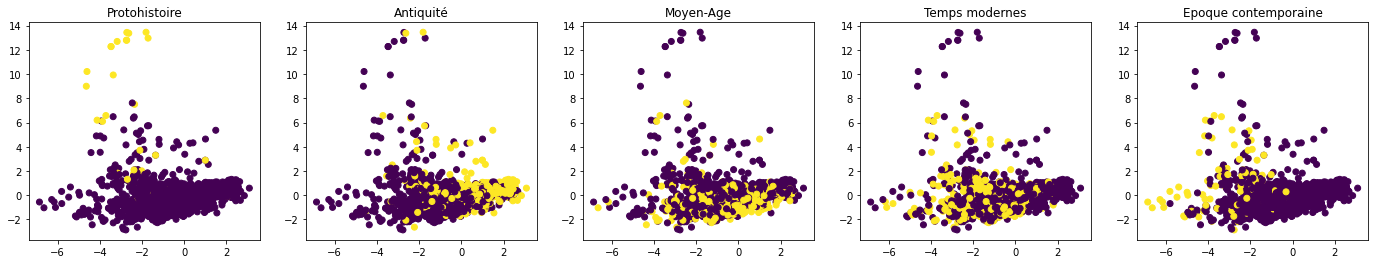

In [130]:
pls_reg(np.concatenate((X1, X4, X2), axis=1))